# Path Analysis Solutions
#### Adam Gibbs     
#### 31 March 2022

This Python notebook contains the full analysis of the two log files path.csv and tracker.csv and attempts to generate as many insights into the errors as possible. A summary of the findings will be written in summary_report.md. The sturcture of the notebook is as follows:
- Unpacking and viewing of the raw data logs
- visulization of the specified path for the robotic arm to follow and the actual path the robotic arm followed based on the optical tracker
- Exploration of how the x, y, and z coordinates vary based on time for both the path and tracker logs
- Exploration of the correlation between path coordinates and tracker coordinates

Some notes for walking through this notebook:
- The word path will be used to refer to data from path.csv
- Sometimes I will refer to the data from path.csv as the "specified path" or "user specified path"
- All visualizations of the data from path.csv will be blue in color
- The word tracker will be used to refer to data from tracker.csv
- Sometimes I will refer to the data from tracker.csv as the "tracker path"
- All visualizations of the data from tracker.csv will be orange in color

# Environment Setup and Loading Data

In [1]:
#IMPORTS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [2]:
# READ IN PATH DATA
path = pd.read_csv("path.csv")

# print first 122 lines of the path.csv log
# 122 was chosen since the first 120 are "registration points"
print(path.head(122))


     Unnamed: 0  index       x_pth       y_pth         z_pth  \
0             0    177  450.000000  700.000000  1.136868e-13   
1             1    178  450.000000  700.000000  0.000000e+00   
2             2    179  450.000000  700.000000  0.000000e+00   
3             3    180  450.000000  700.000000  0.000000e+00   
4             4    181  450.000000  700.000000  0.000000e+00   
..          ...    ...         ...         ...           ...   
117         117    294  450.000000  700.000000  0.000000e+00   
118         118    295  450.000000  700.000000  0.000000e+00   
119         119    296  450.000000  700.000000  0.000000e+00   
120         120    297  452.904966  699.539899  0.000000e+00   
121         121    298  464.524829  697.699493  0.000000e+00   

                   t_pth  
0    1633969004350000000  
1    1633969004400000000  
2    1633969004450000000  
3    1633969004500000000  
4    1633969004550000000  
..                   ...  
117  1633969010200000000  
118  1633969010

In [3]:
# READ IN TRACKER DATA
tracker = pd.read_csv("tracker.csv")

# display and view the first 500 lines of the tracker log file
# 500 was chosen because it shows the transition from "registration" points to tracking points 
print(tracker.head(500))

     Unnamed: 0  index      x_trk      y_trk        z_trk                t_trk
0             0   3180 -36.507133 -40.170982 -2915.784424  1633969004633871000
1             1   3181 -36.543438 -40.260765 -2915.713623  1633969004648860000
2             2   3182 -36.645119 -40.364326 -2915.732910  1633969004662330000
3             3   3183 -36.709301 -40.413754 -2915.772949  1633969004674115000
4             4   3184 -36.720108 -40.421989 -2915.788086  1633969004687849000
..          ...    ...        ...        ...          ...                  ...
495         495   3675 -48.926826 -26.074509 -2961.823486  1633969011236526000
496         496   3676 -48.870758 -26.074509 -2961.822021  1633969011247954000
497         497   3677 -48.848335 -26.070332 -2961.819824  1633969011260401000
498         498   3678 -48.854256 -26.070070 -2961.825684  1633969011275453000
499         499   3679 -48.875694 -26.077665 -2961.834717  1633969011287840000

[500 rows x 6 columns]


In [4]:
# GET NUMPY ARRAYS OF IMPORTANT DATA
# convert columns of the pandas dataframes to numpy array for quicker computations
# keeping x, y, and z coordinates as well as time
# indices are conserved so the ith element of each array corresponds to the ith line of its log file

# path data
pth_x = path["x_pth"].to_numpy()
pth_y = path["y_pth"].to_numpy()
pth_z = path["z_pth"].to_numpy()
pth_t = path["t_pth"].to_numpy()

# tracker data
trk_x = tracker["x_trk"].to_numpy()
trk_y = tracker["y_trk"].to_numpy()
trk_z = tracker["z_trk"].to_numpy()
trk_t = tracker["t_trk"].to_numpy()


In [5]:
# COMBINE LOG TIME SERIES FOR DIRECT COMPARISONS
# use pandas merge_asof function to find the tracker point with the nearest time stamp to each path point
# no limit is placed on how far away the nearest timestamp can be since the timestamps in the log file are fairly close
merged = pd.merge_asof(path, tracker, left_on='t_pth', right_on='t_trk', direction='nearest')

# path data
pth_x_m = merged["x_pth"].to_numpy()
pth_y_m = merged["y_pth"].to_numpy()
pth_z_m = merged["z_pth"].to_numpy()
pth_t_m = merged["t_pth"].to_numpy()

# tracker data
trk_x_m = merged["x_trk"].to_numpy()
trk_y_m = merged["y_trk"].to_numpy()
trk_z_m = merged["z_trk"].to_numpy()
trk_t_m = merged["t_trk"].to_numpy()

# no longer need pd dataframes, delete to save some space
del path, tracker

# Visualize the Specified Path and the Tracker Path
The specified path exists solely in the $xy$ plane, so we first plot the $x$ and $y$ coordinates of the specified path onto 2-Dimensions (See Figure 1 below). Here we see many loops (as expected from what was written in README.md) which all share a common point in the middle of the plot. If we go ahead and create the same plot for the tracker path (See Figure 2 below) we clearly see the same form of many loops but with a clear transformation performed. There appears to be a translation in the $x$ and $y$ directions as well as some rotation and skew. As shown in Figure 3 below, the transformation becomes apparent when the two sets of $xy$ coordinates are plotted onto the same axis. Due to the similar shape, we could go ahead and find a transformation matrix $A$ such that  we can represent the transformation $T$ as $T(\vec{x}) = A\vec{x}$ where $\vec{x}$ is a coordinate in the $xyz$ plane from the specified path. However, in this notebook, the exact transformation matrix tells us exactly how the points get transformed but provides less in terms of where these errors might come from. So, we are going to skip the calculation of the transformation matrix $A$ in preference of analysis of how the different coordinates between the path and tracker correlate and look for insights there.  

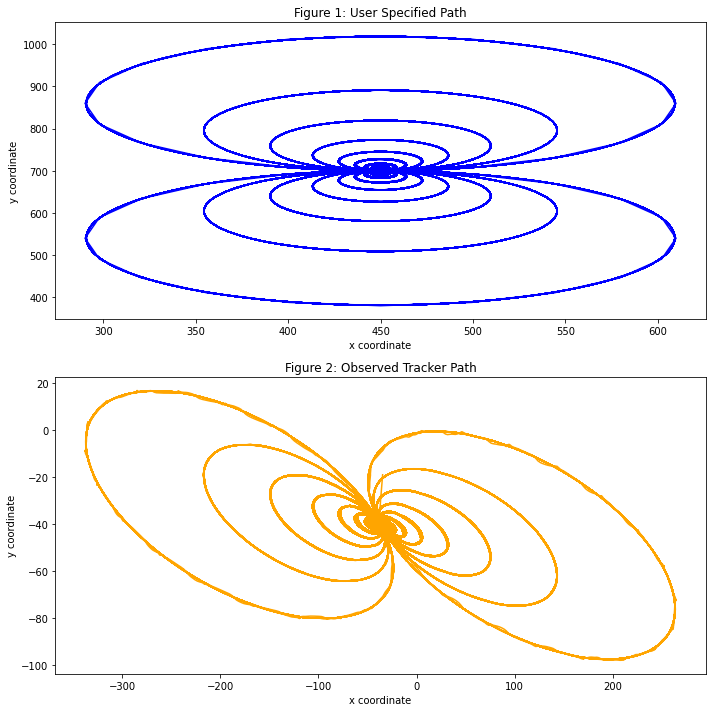

In [6]:
# EXPLORE DESIRED SPECIFIED PATH AND OBSERVED TRACKED PATH

figure, axes = plt.subplots(2,1, figsize=(10,10))

plt1 = axes[0]
plt1.plot(pth_x, pth_y, c='blue')
plt1.set_xlabel('x coordinate')
plt1.set_ylabel('y coordinate')
plt1.set_title('Figure 1: User Specified Path')

plt2 = axes[1]
plt2.plot(trk_x, trk_y, c='orange')
plt2.set_xlabel('x coordinate')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 2: Observed Tracker Path')

# save and show figs
plt.tight_layout()
plt.savefig('./figs/figures12_individual_xy.png', facecolor='white')
plt.show()


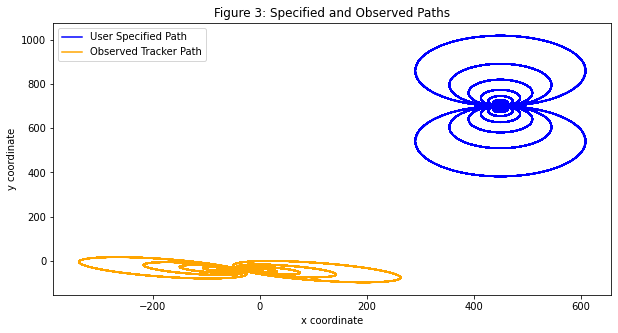

In [7]:
# PLOT PATH AND TRACKER ON SAME AXIS

# create figure to plot onto
figure, ax = plt.subplots(1,1, figsize=(10,5))

# plot points
ax.plot(pth_x, pth_y, c='blue', label='User Specified Path')
ax.plot(trk_x, trk_y, color='orange', label='Observed Tracker Path')
# label figure
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_title('Figure 3: Specified and Observed Paths')
ax.legend()
# save and show figure
plt.savefig("./figs/figure3_combined_xy.png", facecolor='white')
plt.show()

# Specified Path Analysis
Here in Figures 4, 5, and 6 we visualize how the $x$, $y$, and $z$ coordinates of the specified path, respectively, vary based on time. Since the path specifies multiple loops in the $xy$ plance we see multiple sinusodial-like functions with changing amaplitudes and frequencies for the $x$ vs time and $y$ vs time Figures. For the $z$ vs time figure, we see the inital point being a very small non-zero value and the remaining values all being 0.  

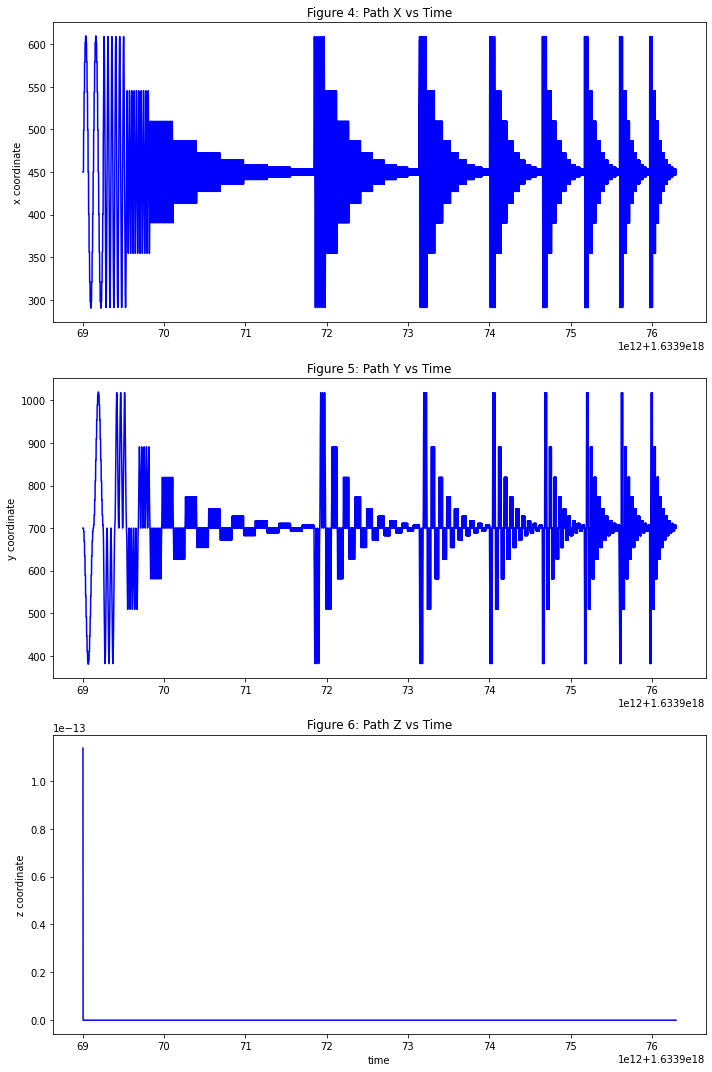

In [8]:
# EXPLORE SPECIFIED PATH VS TIME

# create figure to plot onto
fig, ax = plt.subplots(3,1, figsize=(10,15))

# plot and label figure for x coord vs time 
plt1 = ax[0]
plt1.plot(pth_t, pth_x, c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 4: Path X vs Time')

# plot and label figure for z coord vs time 
plt2 = ax[1]
plt2.plot(pth_t, pth_y, c='blue')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 5: Path Y vs Time')

# plot and label figure for z coord vs time 
plt3 = ax[2]
plt3.plot(pth_t, pth_z, c='blue')
plt3.set_xlabel('time')
plt3.set_ylabel('z coordinate')
plt3.set_title('Figure 6: Path Z vs Time')

# show plot
plt.tight_layout()
plt.savefig("./figs/figures456_Pvt.png", facecolor='white')
plt.show()

# Tracker Path Analysis
Here in figures 7, 8, and 9 we visualize how the $x$, $y$, and $z$ coordinates of the tracker path, respectively, vary based on time. Similar to the figures about for the specified path, we see sinusodial-like functions for $x$ vs time and $y$ vs time, but they vary from the plots we see for $x$ vs time and $y$ vs time for the specified path. We'll explore the difference more in detail deeper in the notebook, but the changes in amplitudes (and not by a uniform scalar) are the major difference you can see by eye between the specified and tracker paths. Further, here we see another sinusodial like function for the $z$ coordinate which drastically varies from what we see with the specified path. The $z$ vs time graph looks very similar to the $y$ vs time figure which is drastically different from the specified path $z$ vs time. 

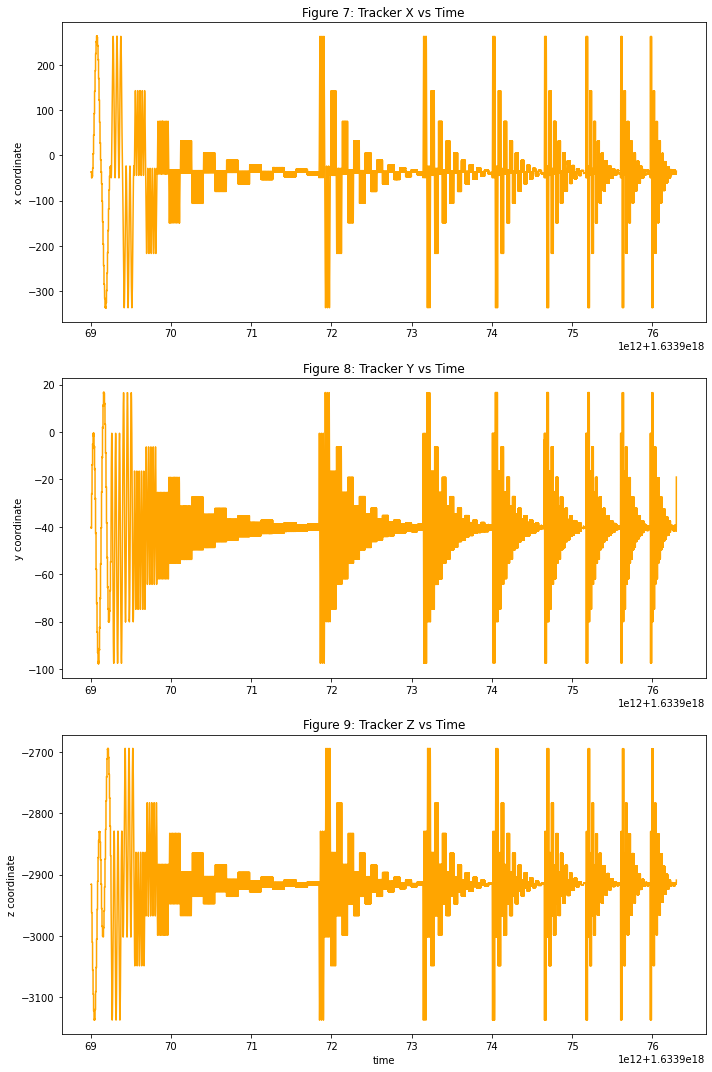

In [9]:
# EXPLORE TRACKER COORDINATES VS TIME
fig, ax = plt.subplots(3, 1, figsize=(10,15))

plt1 = ax[0]
plt1.plot(trk_t, trk_x, c='orange')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 7: Tracker X vs Time')

plt2 = ax[1]
plt2.plot(trk_t, trk_y, c='orange')
plt2.set_ylabel('y coordinate')
plt2.set_title('Figure 8: Tracker Y vs Time')

plt3 = ax[2]
plt3.plot(trk_t, trk_z, c='orange')
plt3.set_xlabel('time')
plt3.set_ylabel('z coordinate')
plt3.set_title('Figure 9: Tracker Z vs Time')

plt.tight_layout()
plt.savefig("./figs/figures789_Tvt.png", facecolor='white')
plt.show()

# Exploring Coordinates vs Time
To begin to create insights on why the tracker path has errors, we will use the coordinate vs time plots above to begin to explore how the specified path points relate to the observed tracker coordinates. In expectation, we'd expect the path $x$ coordinates to line up with the tracker x coordinates and the same for the $y$ and $z$ coordinates as well. We first calculate simple translations between the path and tracker coordinates to make comparisons easier. We also zoom in on the first set of loops to be better able to see smaller discrepancies. 

In [10]:
# Find the ratio of specified points vs tracked points to plot subsets of roughly the same size
path_size = pth_t.size
tracker_size = trk_t.size
size_ratio = tracker_size / path_size

# specify the size of subsets to plot for following plots
num_points = 50000
trk_num_points = round(num_points*size_ratio)

# find trnaslations in x, y, and z directions to be able to compare amplitudes more easily
x_translation = pth_x[0] - trk_x[0]
y_translation = pth_y[0] - trk_y[0]
z_translation = pth_z[0] - trk_z[0]

# calculate and store translated tracker path coordinates
trk_x_t = trk_x + x_translation
trk_y_t = trk_y + y_translation
trk_z_t = trk_z + z_translation

## X Coordinate
Here we again see the $x$ vs time plots for both the path and tracker (these are the same figures shown above in different groups). These plots, over roughly the same time domain, have very few similarities. The $x$ coordinate range at different subsets of the time, are completely different and the pattern seen is noticeably different. Also, if we approximate the range of the plotted points on each plot by looking at the graph, the range of the path $x$ coordinate seems to be roughly 300 while the range of the tracker $x$ coordinate seems to be roughly 600. This could be the result of some scaling of around 2, but we'll reassess after exploring the other coordinates. 

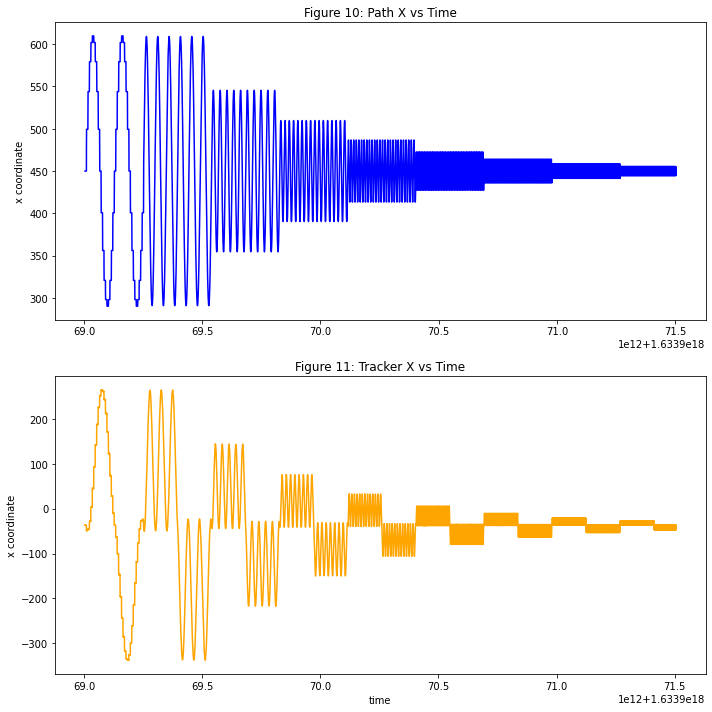

In [11]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path x coordinates
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_x[:num_points], c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title('Figure 10: Path X vs Time')

# plot tracker x coordinates
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('x coordinate')
plt2.set_title('Figure 11: Tracker X vs Time')

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figures1011_XvT.png', facecolor='white')
plt.show()

## Y Coordinate
Here we made the same visualizations for the $y$ coordinates as we did with the $x$ coordinates. We see a very similar pattern as with the $x$ coordinate as the path $y$ vs time and the tracker $y$ vs time seem to have very little correlation. However, here we notice that the path $y$ vs time plot (figure 12) looks very similar to the tracker $x$ vs time (figure 11) and, to a lesser extent, the path $x$ vs time (figure 10) looks similar to the tracker $y$ vs time (figure 13). This could begin to provide an insight into how the translation errors occured between the specified path and the tracker path. Potentially, the $x$ and $y$ coordinates of the specified path got flipped when given to the robotic arm to follow. In general, this wouldn't necessarily be an arror if the arm is working on a uniform material as it'd have the same result just rotated and flipped with respect to the coordinate plane. If the material is not uniform, then this would cause errors and would be the first issue to look into. We explore the correlation between path $x$ and tracker $y$ and between path $y$ and tracker $x$ later in the notebook.   

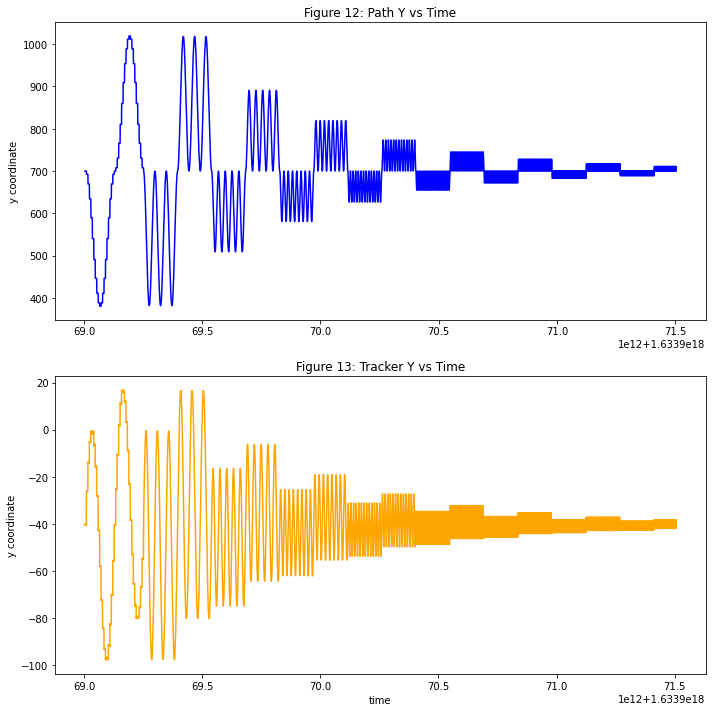

In [12]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path Y 
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_y[:num_points], c='blue')
plt1.set_ylabel('y coordinate')
plt1.set_title("Figure 12: Path Y vs Time")

# plot tracker Y
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('y coordinate')
plt2.set_title("Figure 13: Tracker Y vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1213_YvT.png', facecolor='white')
plt.show()


## Z Coordinate
Here we again explore the $z$ coordinate as we did with the $x$ and $y$ coordinates. Here we see the biggest discrepancy as the specified path has no $z$ coordinate values specified, but the tracker path $z$ coordinates follow a similar pattern to the $x$ and $y$ coordinates of the path and tracker. This suggests that there is some mistake in how the $x$ and $y$ coordinates from the specified path get communicated to, transformed by, and executed by the robotic arm. This probably provides some explaination as to why we see such a big skew on the tracker path in the $xy$ plane. More to come on this later in the notebook.  

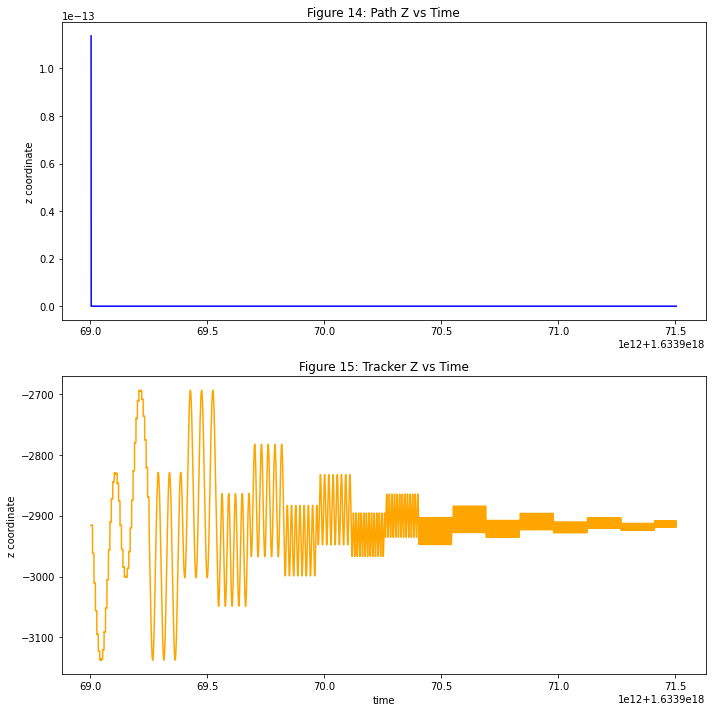

In [13]:
# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot path z vs time
plt1 = ax[0]
plt1.plot(pth_t[:num_points], pth_z[:num_points], c='blue')
plt1.set_ylabel('z coordinate')
plt1.set_title('Figure 14: Path Z vs Time')

# plot tracker z vs time
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('z coordinate')
plt2.set_title('Figure 15: Tracker Z vs Time')

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1415_ZvT.png', facecolor='white')
plt.show()


# Correlations Between Different Coordinates
In the following plots we explore some of the similarities we noticed above. The following comparisons are in this section:
- Tracker $y$ vs time and Tracker $z$ vs time
- Path $x$ vs time and Tracker $y$ vs time
- Path $y$ vs time and Tracker $x$ vs time


## Tracker $y$ vs time and Tracker $z$ vs time
The biggest discrepancy between the path and tracker was the precense of a pattern in the tracker $z$ coordinates. This pattern was very similar to that of the $y$ coordinates vs time of the tracker, so we plot the two next to each other. Both show similarities to path $x$ vs time (figure 10). In path $x$ vs time there are subsets of the domain where we see sinusodial like functions of different amplitudes which correspond to loops of different sizes on the $xy$ plane. However, in figures 16 and 17 below, these sections of the same amplitude are split down the middle and one half is translated up and the other half translated down. No major insight was gained from this and we tried combining (through addition, subtraction, and multiplication of scalars) the two plots to see if we could match closely the patterns seen in the path $x$ vs time plot (figure 10), but no simple linear combination was found. However, it does appear as though the presence of $z$ coordinates in the tracker path has some connection to the skew in the tracker $y$ coordinates in that the sections of translated points seems like it must be more than a coincedence. 
 

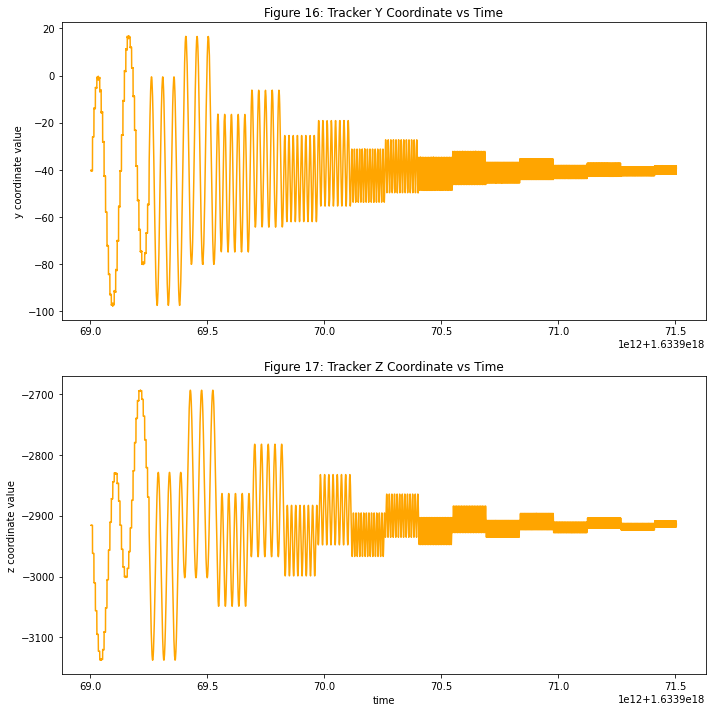

In [14]:
# create figure to plot onto 
figure, axes = plt.subplots(2,1, figsize=(10,10))

# plot tracker y
plt1 = axes[0]
plt1.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt1.set_ylabel('y coordinate value')
plt1.set_title("Figure 16: Tracker Y Coordinate vs Time")

# plot tracker z
plt2 = axes[1]
plt2.plot(trk_t[:trk_num_points], trk_z[:trk_num_points], c='orange')
plt2.set_xlabel("time")
plt2.set_ylabel('z coordinate value')
plt2.set_title("Figure 17: Tracker Z Coordinate vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1617_T_YZvt.png', facecolor='white')
plt.show()


## Path $x$ vs time and Tracker $y$ vs time
As mentioned before, the patterns in path $x$ vs time and tracker $y$ vs time are very similar. First, we plotted both the time series on their own axis and compared. Next, we transform the path $x$ coordinates by adding the difference between the initial points and scaling based on the min and max values on our domain. Then we plotted both the time series on the same axis and by scaling based on only the min and max values across the entire domain, the rest of the plot lined up perfectly, except for the alternating amplitude mentioned before. It appears as if most of the peaks get cut off early in a regular pattern. This doesn't explain much as to why, but there seems to be error when getting toward the extreme values of coordinates during loops. 

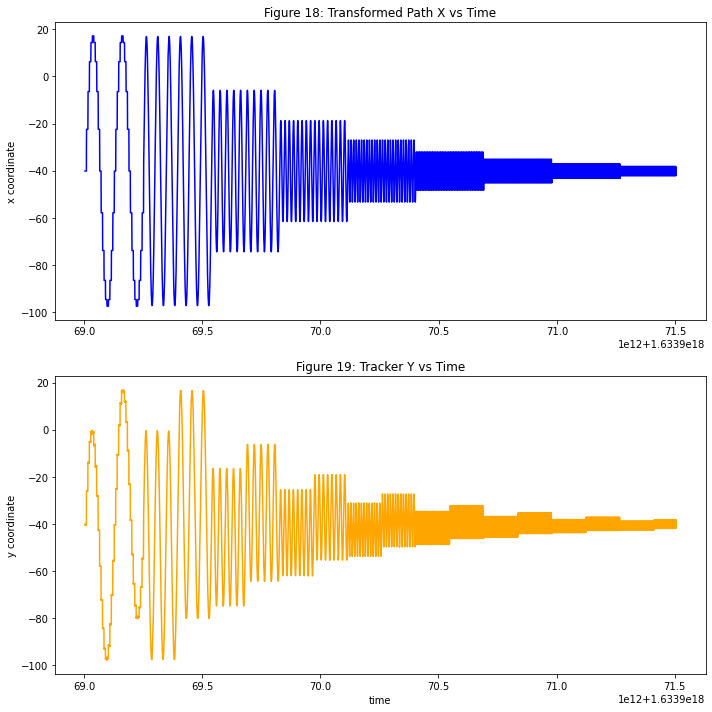

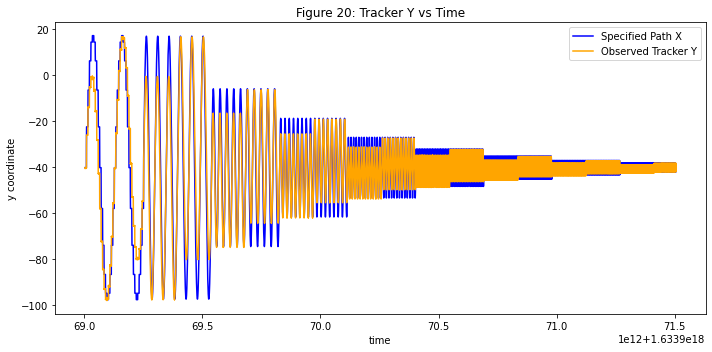

In [15]:

# find scalar and translation from path x to tracker y
range_pth = max(pth_x) - min(pth_x)
range_trk = max(trk_y) - min(trk_y)
rto = range_pth / range_trk
# scale path x
scaled_pth_x = pth_x[:num_points] / rto
# translate path x
first_point_diff = scaled_pth_x[0] - trk_y[0]
transformed_pth_x = scaled_pth_x - first_point_diff

# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot transformed path x
plt1 = ax[0]
plt1.plot(pth_t[:num_points], transformed_pth_x[:num_points], c='blue')
plt1.set_ylabel('x coordinate')
plt1.set_title("Figure 18: Transformed Path X vs Time")

# plot tracker y
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('y coordinate')
plt2.set_title("Figure 19: Tracker Y vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures1819_PXvTY.png', facecolor='white')
plt.show()


# create figure to plot onto
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# plot transformed path x
ax.plot(pth_t[:num_points], transformed_pth_x[:num_points], c='blue', label='Specified Path X')
# plot tracker y onto same figure
ax.plot(trk_t[:trk_num_points], trk_y[:trk_num_points], c='orange', label='Observed Tracker Y')
ax.set_xlabel('time')
ax.set_ylabel('y coordinate')
ax.set_title("Figure 20: Tracker Y vs Time")
ax.legend()

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figure20_overlapped_PXvTY.png', facecolor='white')
plt.show()


## Path $y$ vs time and Tracker $x$ vs time
Here we perform the same comparison as the previous section, putting both plots side by side and then overlapping them. We again transform path $y$ to be able to properly compare them when overlapping them - here a translation and inversion is sufficient. Here the two plots line up nearly perfectly, expect we again see the regular occurance of the extreme values getting cut off in the tracker path. We can even analyze the error between the time series using the mean absolute error and our merged time series from before. When we calculate it we get a MAE of approximately 17 which is relatively small, but obviously not perfect by any means. 

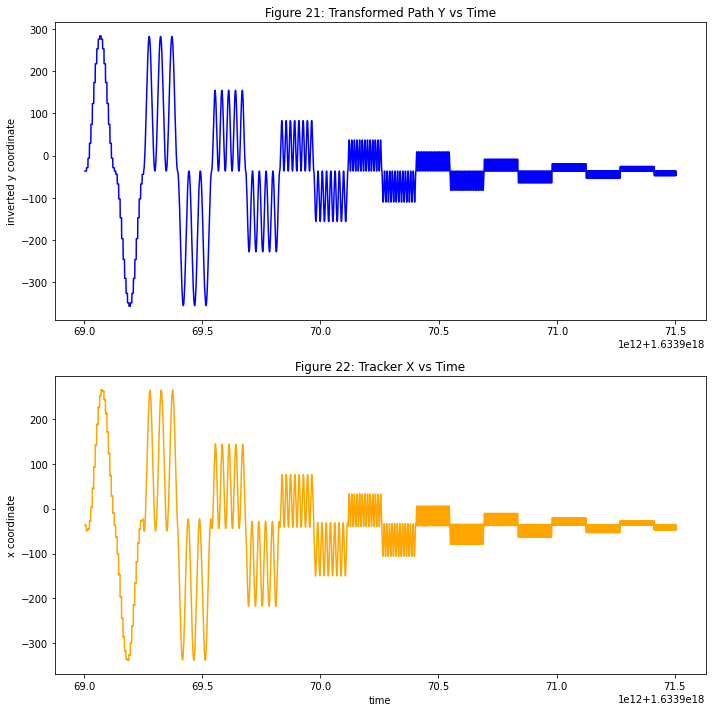

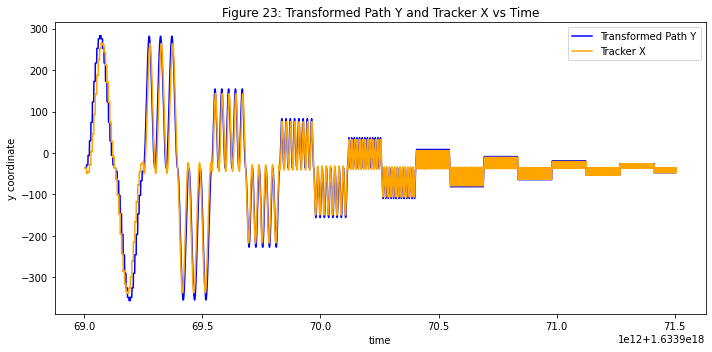

Mean absolute error:  16.512014511746084


In [16]:
# transform path y
# translate and invert path y
first_point_diff = -1*pth_y[0] - trk_x[0]
transformed_pth_y = -1*pth_y - first_point_diff

# create figure to plot onto
fig, ax = plt.subplots(2, 1, figsize=(10,10))

# plot transformed path y 
plt1 = ax[0]
plt1.plot(pth_t[:num_points], transformed_pth_y[:num_points], c='blue')
plt1.set_ylabel('inverted y coordinate')
plt1.set_title("Figure 21: Transformed Path Y vs Time")

# plot tracker x
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange')
plt2.set_xlabel('time')
plt2.set_ylabel('x coordinate')
plt2.set_title("Figure 22: Tracker X vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures2122_PYvTX.png', facecolor='white')
plt.show()


# create figure to plot onto
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# plot transformed path y
ax.plot(pth_t[:num_points], transformed_pth_y[:num_points], c='blue', label='Transformed Path Y')
# plot tracker x on same axis
ax.plot(trk_t[:trk_num_points], trk_x[:trk_num_points], c='orange', label='Tracker X')
ax.set_xlabel('time')
ax.set_ylabel('y coordinate')
ax.set_title("Figure 23: Transformed Path Y and Tracker X vs Time")
ax.legend()

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figure23_overlapped_PYvTX.png', facecolor='white')
plt.show()

# first point of path y
first_point_diff = -1*pth_y_m[0] - trk_x_m[0]
transformed_pth_y_m = -1*pth_y_m - first_point_diff
# calculate mae
print("Mean absolute error: ", mae(transformed_pth_y_m[:num_points], trk_x_m[:num_points]))

# Zoomed In Visualizations
Since we notice some error coming around the peaks within the time series, we can zoom in and get a closer look at what's going on. We zoom in on the path $x$ vs tracker $y$ and path $y$ vs tracker $x$ comparisons in the following figures. Here, if you look closely at the peaks, you can see in the tracker plots, there is a small notch missing that is present in the path plots. That is, the peak of the tracker plots appears to get minorly cut off. So, we can say there may be some error involved when the robotic arm changes direction in any dimension (i.e. from increasing in the $x$ direction to decreasing in the $x$ dimension).  

In [17]:
# change subset of points to be smaller to get zoomed in view of plots
num_points_zoom = 5000
trk_num_points_zoom = round(num_points_zoom*size_ratio)

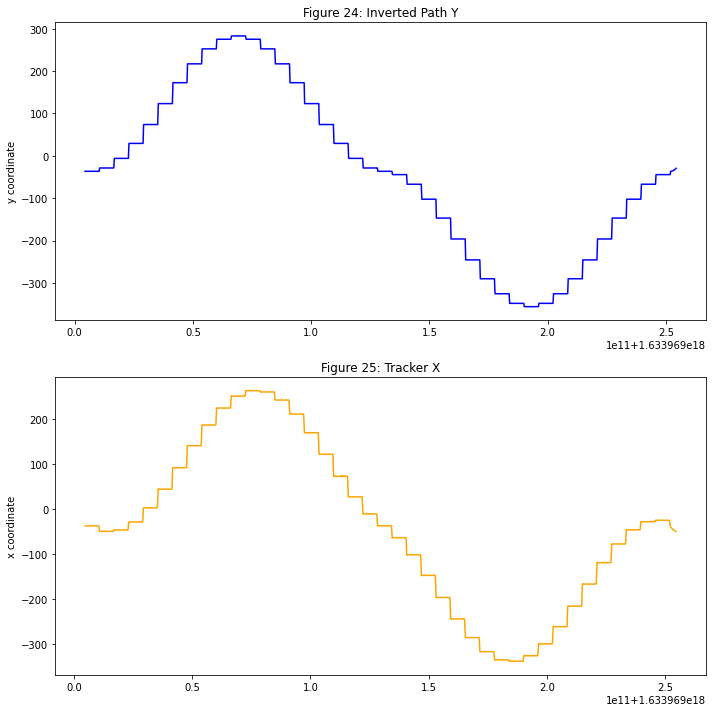

In [18]:
# transform merged path y (same as above)
first_point_diff = -1*pth_y_m[0] - trk_x_m[0]
transformed_pth_y_m = -1*pth_y_m - first_point_diff

# create figure to plot onto
figure, ax = plt.subplots(2,1, figsize=(10,10))

# plot inverted path y on smaller domain
plt1 = ax[0]
plt1.plot(pth_t_m[:num_points_zoom], transformed_pth_y_m[:num_points_zoom], c='blue')
plt1.set_ylabel('y coordinate')
plt1.set_title("Figure 24: Inverted Path Y")

# plot tracker x on smaller domain
plt2 = ax[1]
plt2.plot(trk_t[:trk_num_points_zoom], trk_x[:trk_num_points_zoom], c='orange')
plt2.set_ylabel('x coordinate')
plt2.set_title("Figure 25: Tracker X")

#save and show figures
plt.tight_layout()
plt.savefig('./figs/figures2425_zoom_PYvTX.png', facecolor='white')
plt.show()

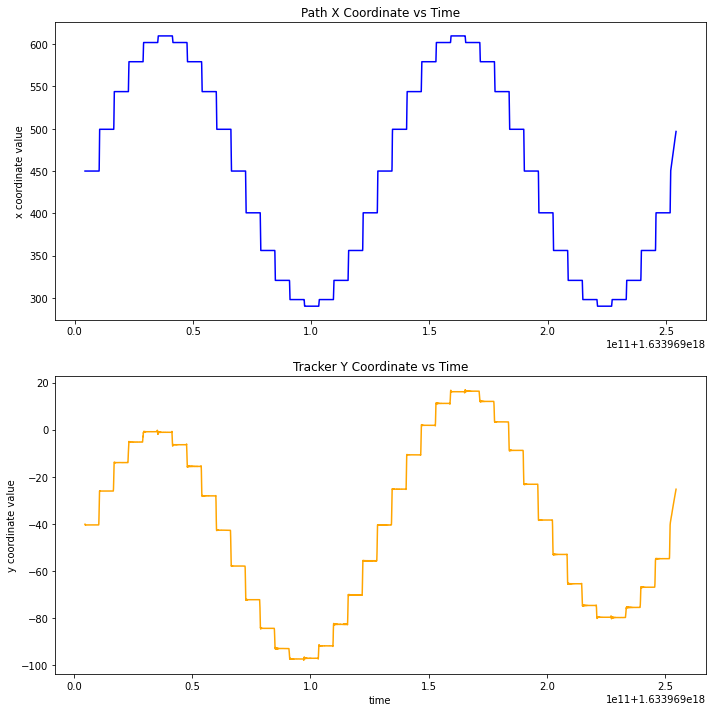

In [19]:
# create figure to plot onto
figure, axes = plt.subplots(2,1, figsize=(10,10))

# plot path x
plt1 = axes[0]
plt1.plot(pth_t[:num_points_zoom], pth_x[:num_points_zoom], c='blue')
plt1.set_ylabel('x coordinate value')
plt1.set_title("Path X Coordinate vs Time")

# plot tracker y
plt2 = axes[1]
plt2.plot(trk_t[:trk_num_points_zoom], trk_y[:trk_num_points_zoom], c='orange')
plt2.set_xlabel("time")
plt2.set_ylabel('y coordinate value')
plt2.set_title("Tracker Y Coordinate vs Time")

# save and show figures
plt.tight_layout()
plt.savefig('./figs/figures2627_zoom_PXvTY.png', facecolor='white')
plt.show()


# 3D Plots: Projection into 3D?
It could be seen in our 2D analysis in the $xy$ plane that there were errors as we expected when we began this analysis and one of the biggest questions is the presence of $z$ coordinates in the tracker log. So, to get a full picture of what is going on, we need to be able to see what is going on in three dimensions. So, we plot the x, y, and z coordinates onto a 3D plot for both the specified path and the tracker path. As expected we get the loops on the $xy$ plane and one intial point straying slight upward in the $z$ direction but with very little significance. However, the surprise comes from the tracker plot which shows the exact same loops as the specified path, but it only appears in three dimensions. So, the skewed image we saw on the $xy$ plane before was the projection of the specified path in three dimensions projected onto the $xy$ plane. Thus, one can infer that at some point between the specified path being given and the robotic arm following the paths, the specified path got projected into three dimensions via some transformation. Now, the question becomes can we figure out when this error might be occuring? 

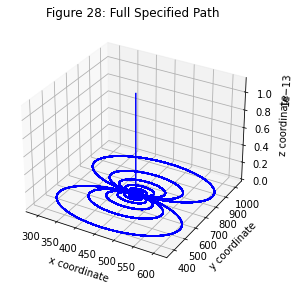

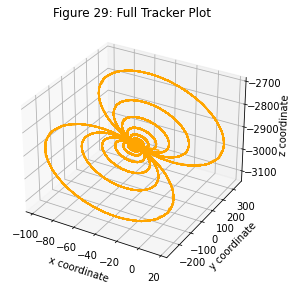

In [20]:
# specify the size of subsets to plot for following plots
num_points = 3200
trk_num_points = round(num_points*size_ratio)

# create 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot path x,y,z 
ax.plot3D(pth_x, pth_y, pth_z, 'blue')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 28: Full Specified Path')

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figure28_3d_path.png', facecolor='white')
plt.show()

# create another 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot tracker x,y,z
ax.plot3D(trk_y, -trk_x, trk_z, 'orange')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 29: Full Tracker Plot')

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figure29_3d_tracker.png', facecolor='white')
plt.show()


# Path in $xy$ plane vs Time
After seeing the non-distorted loops in the 3D plots above, my next question became, did this occur due to hiccups in the robotic arm or an error in the translation from given points to machine-readable code? To test this I wanted to see how the plots developed as time proceeded and more points were read in. The below plots, figure 30, show the loops in the $xy$ plane after certain periods of time. Time is measured in the number of points it has read in and the tracker path tracks roughly 3.75 points for every point the specified path has. But we also use the merged time series, figure 31, to plot the points from the specified path and tracker path that are the closest together in terms of time.   

From these plots it appears as if the robotic arm is tracking the movements it is told to do quite well and I mean this in terms of corresponding parts of loops are finished at the same timestamp specified in the specified path. There are no hangups around certain points that makes the arm fall behind which implies that the error is a result of some mistranslation between the given code or machine code, or there is a calibration error in the robot that it thinks it is going to the correct points but there is a skew in the calibration. And this pattern can also be seen when we make the same plots in 3D. The loops appear to be created just fine in the 3D space.

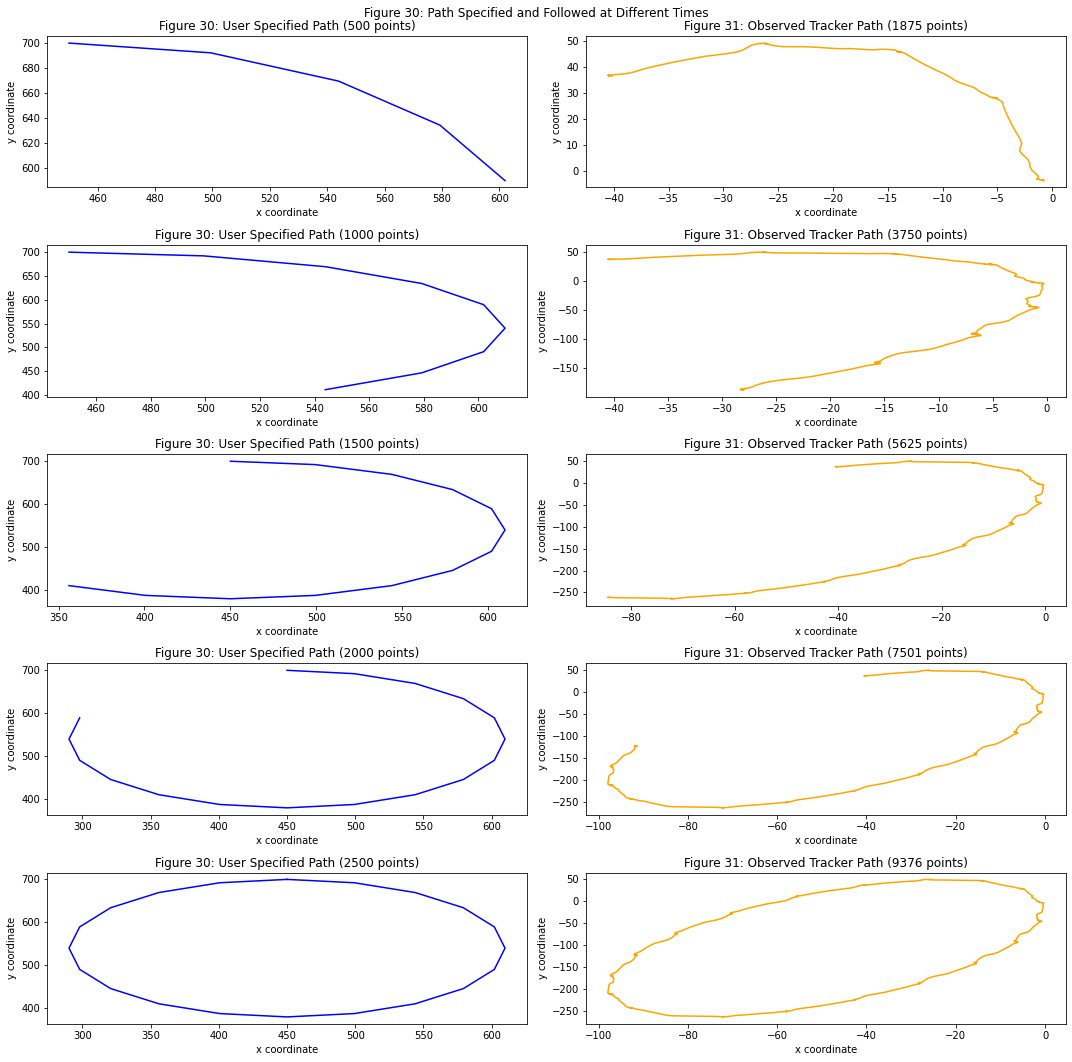

In [21]:

# create figure to plot onto
fig, ax = plt.subplots(5,2, figsize=(15,15))

# plot the path in the xy plane after i number of points for different values of i 
for i in range(0, 5):
    # plot path x and y
    num_points = 500*i + 500
    plt0 = ax[i][0]
    plt0.plot(pth_x[:num_points], pth_y[:num_points], c='blue')
    plt0.set_xlabel("x coordinate")
    plt0.set_ylabel('y coordinate')
    title0 =  "Figure 30: User Specified Path (" + str(num_points) + " points)"
    plt0.set_title(title0)

    # plot tracker x and y 
    trk_num_points = round(num_points*size_ratio)
    plt1 = ax[i][1]
    plt1.plot(trk_y[:trk_num_points], -trk_x[:trk_num_points], c='orange')
    plt1.set_xlabel("x coordinate")
    plt1.set_ylabel('y coordinate')
    title1 = "Figure 31: Observed Tracker Path (" + str(trk_num_points) + " points)"
    plt1.set_title(title1)

# give figure a main title
plt.suptitle("Figure 30: Path Specified and Followed at Different Times")

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figure30_time_path.png', facecolor='white')
plt.show()

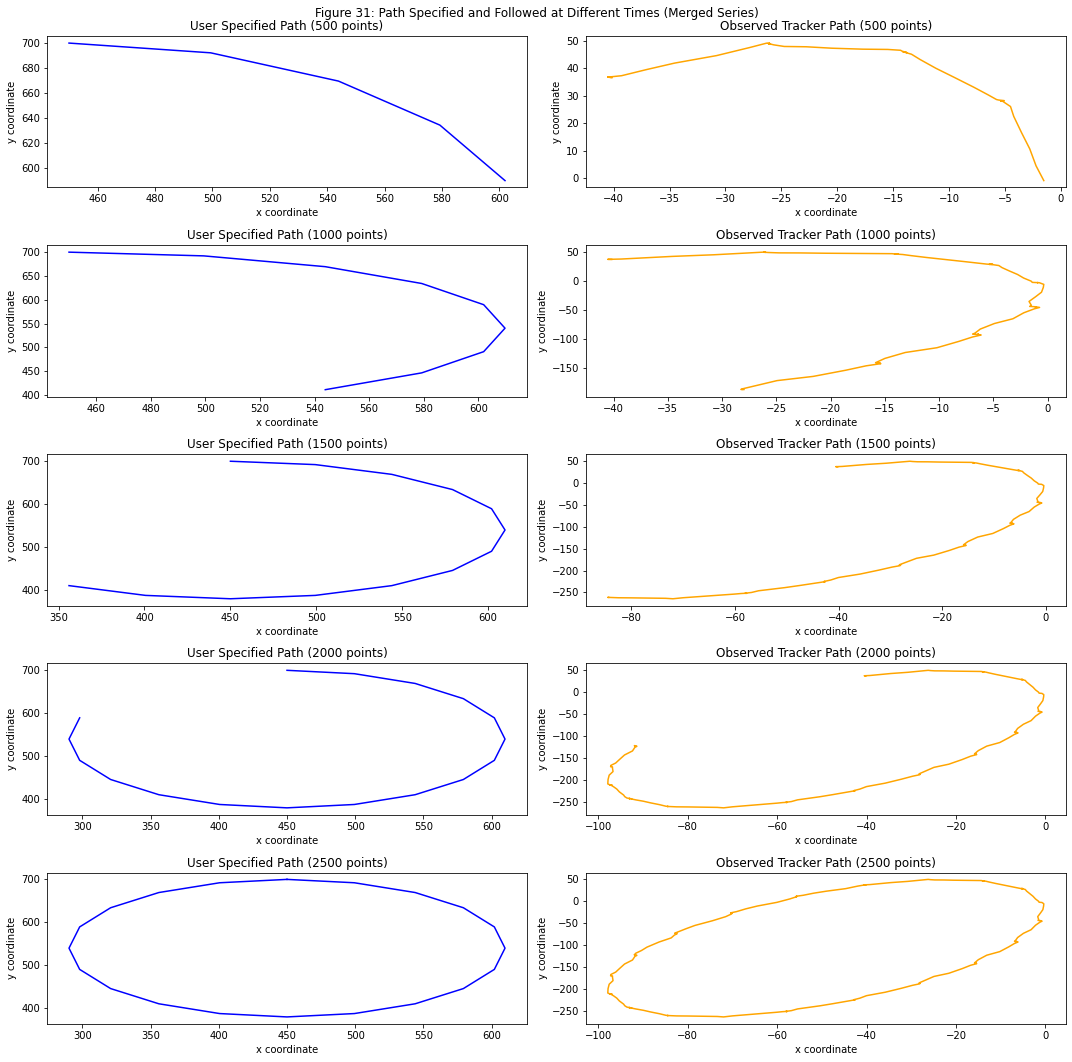

In [22]:

# create figure to plot onto
fig, ax = plt.subplots(5,2, figsize=(15,15))

# plot the path in the xy plane after i number of points for different values of i 
for i in range(0, 5):
    # plot path x and y 
    num_points = 500*i + 500
    plt0 = ax[i][0]
    plt0.plot(pth_x[:num_points], pth_y[:num_points], c='blue')
    plt0.set_xlabel("x coordinate")
    plt0.set_ylabel('y coordinate')
    title0 =  "User Specified Path (" + str(num_points) + " points)"
    plt0.set_title(title0)

    # plot tracker x and y
    trk_num_points = round(num_points*size_ratio)
    plt1 = ax[i][1]
    plt1.plot(trk_y_m[:num_points], -trk_x_m[:num_points], c='orange')
    plt1.set_xlabel("x coordinate")
    plt1.set_ylabel('y coordinate')
    title1 = "Observed Tracker Path (" + str(num_points) + " points)"
    plt1.set_title(title1)

# give figure a main title
plt.suptitle("Figure 31: Path Specified and Followed at Different Times (Merged Series)")

# save and show figure
plt.tight_layout()
plt.savefig('./figs/figure31_merged_time_path.png', facecolor='white')
plt.show()

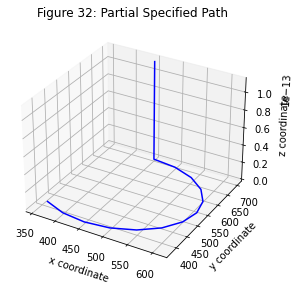

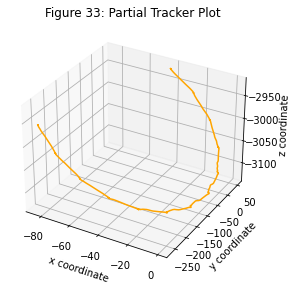

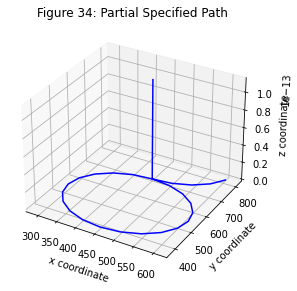

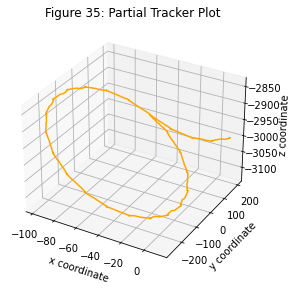

In [23]:
# specify the size of subsets to plot for following plots
num_points = 1500
trk_num_points = round(num_points*size_ratio)

# create 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot path x,y,z 
ax.plot3D(pth_x[:num_points], pth_y[:num_points], pth_z[:num_points], 'blue')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 32: Partial Specified Path')

# show figure
plt.tight_layout()
plt.show()

# create another 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot tracker x,y,z
ax.plot3D(trk_y[:trk_num_points], -trk_x[:trk_num_points], trk_z[:trk_num_points], 'orange')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 33: Partial Tracker Plot')

# show figure
plt.tight_layout()
plt.show()

# specify the size of subsets to plot for following plots
num_points = 3000
trk_num_points = round(num_points*size_ratio)

# create 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot path x,y,z 
ax.plot3D(pth_x[:num_points], pth_y[:num_points], pth_z[:num_points], 'blue')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 34: Partial Specified Path')

# show figure
plt.tight_layout()
plt.show()

# create another 3D compatible figure to plot onto
figure = plt.figure()
ax = plt.axes(projection='3d')

# plot tracker x,y,z
ax.plot3D(trk_y[:trk_num_points], -trk_x[:trk_num_points], trk_z[:trk_num_points], 'orange')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
ax.set_title('Figure 35: Partial Tracker Plot')

# show figure
plt.tight_layout()
plt.show()

# Conclusions
Given the raw log files from the specified path in path.csv and the observed path in tracker.csv we can draw some insight into why the robotic arm is not working the way it should, but more investigation would definitely be needed. There clearly are errors in the tracker path, but we can make the following conclusions that could help lead toward the root cause.

- The general form of the loops in the $xy$ plane are preserved in the tracker path, but with an obscure transform that significantly distorts the loops which suggests the error is in how the specified path is translated into machine readable points.
- In some of the time series plots, especially the zoomed in ones, the peaks of the plots appear to get cut off often. This could be an issue in the robotic arms ability to change direction so it has to plateau some of the peaks, or another visual result of trying to interpret the 3D projection in 2D plots.
- The form of the loops appears to be perfectly preserved in 3D as the specified loops in the $xy$ plane seem to be projected into 3D
    - This is supported not only by the 3D plots but also in the $y$ vs time and $z$ vs time plots of the tracker path which both exhibit similar patterns to that seen in path $x$ but not exactly the same. Also the presence of $z$ coordinate values other than 0 at all suggests this.
- Although the observed track appears shaky and imprecise (could be the robotic arm itself or limitations of the optical tracker), the robotic arm hits corresponding points on the loops at the correct times specified in path.csv which suggests the error does not come from an inability to mechanically follow certain points or patterns of points
    - However, it does appear that the robotic arm misses the specified points often and has to quickly correct itself, but it always appears to get back on track.
- **Overall, it follows from all the observations that the errors arise in either code translation from specified points to machine readable points or there is some form of calibration error in the mechanics of the robotic arm that causes the machine to follow a path different than the one it believes it is following.** 
- **The errors also appear to be general and not restricted to any specific points or patterns of points. All points appear to be projected accurately into 3D, preserving its true form there but not in the $xy$ plane where it is desired.**